In [2]:
! pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

Using device (Note: SB3 manages its own device placement): cpu
Graduation requires avg reward/steps over last 50 eps >= threshold for 5 consecutive checks (each after 10240 timesteps).
Periodic stats printed over last 100 episodes.

=== SINGLE STAGE TRAINING MODE ACTIVE ===
Using optimized parameters for shortened training schedule
Scheduler parameters: LR decay 3.0e-04 → 5.0e-05, Clip 0.30 → 0.10, Entropy (cosine) 0.100 → 0.010
Total training timesteps: 5120000
Total Expected Timesteps across all stages (for global schedulers): 5120000
Using Fixed Step Thresholds for Graduation:
    Stage 0 (Patients: 5): Reward Thresh=None, Steps Thresh(<)=None
MOVE_COST: -1, TIME_EXPIRED_PENALTY: -50
Max State Dimension across all CL stages: 28
>>> CONTINUE_TRAINING flag is False. Starting training from scratch.

>>> Starting training from scratch based on CL_STAGES definition.

Starting/Continuing Curriculum Stage 0
Config: Patients=5, CritD=20, NonCritD=40, MaxEpSteps=None
Max Timesteps for Stage:

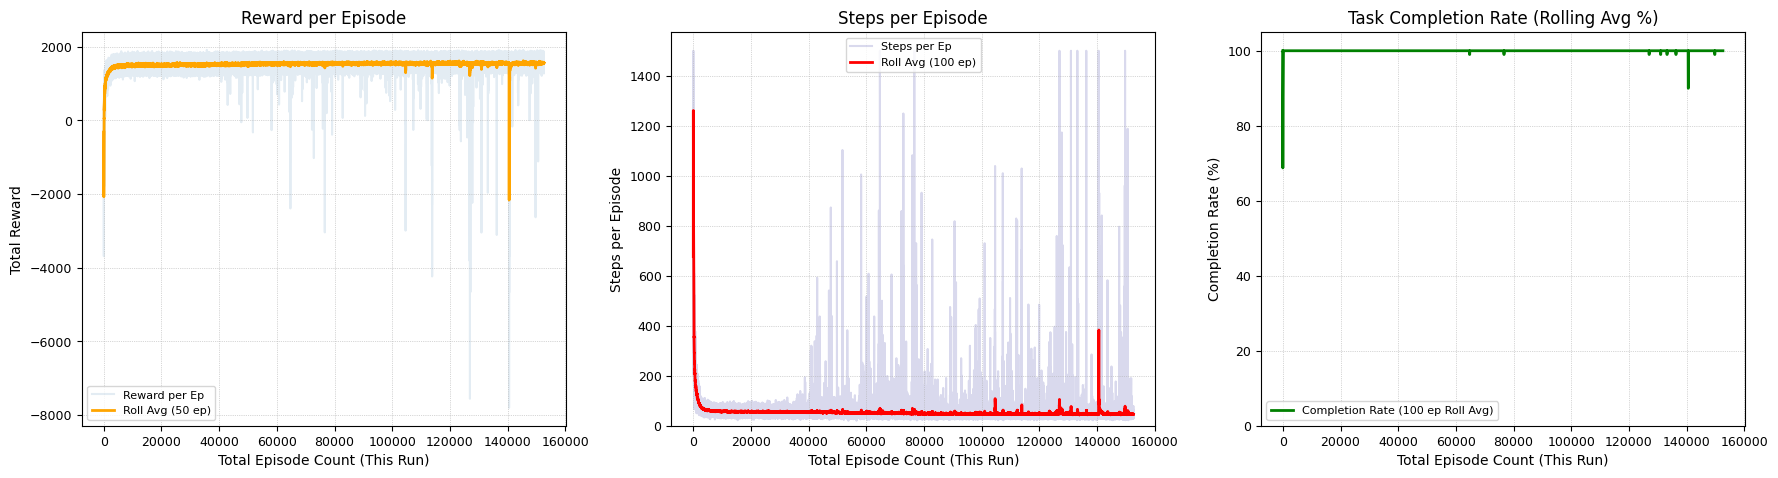


Loading best model from ./ppo_modified_taxi_best.zip for evaluation...
Best model loaded successfully for evaluation.

Starting evaluation using final stage settings...

--- Running Stochastic Evaluation (100 episodes) ---
  Stochastic Eval Ep 10/100 done. R=1581.5, S=53, C=True
  Stochastic Eval Ep 20/100 done. R=1473.0, S=36, C=True
  Stochastic Eval Ep 30/100 done. R=1647.1, S=43, C=True
  Stochastic Eval Ep 40/100 done. R=1534.3, S=43, C=True
  Stochastic Eval Ep 50/100 done. R=1823.0, S=46, C=True
  Stochastic Eval Ep 60/100 done. R=1478.0, S=60, C=True
  Stochastic Eval Ep 70/100 done. R=1456.0, S=45, C=True
  Stochastic Eval Ep 80/100 done. R=1474.7, S=43, C=True
  Stochastic Eval Ep 90/100 done. R=1575.0, S=53, C=True
  Stochastic Eval Ep 100/100 done. R=1465.0, S=50, C=True

--- Running Deterministic Evaluation (100 episodes) ---
  Deterministic Eval Ep 10/100 done. R=1445.8, S=47, C=True
  Deterministic Eval Ep 20/100 done. R=1662.3, S=43, C=True
  Deterministic Eval Ep 30/1

In [16]:
from re import M
import gym
import gymnasium # SB3 uses gymnasium
from gymnasium import spaces # For defining observation space correctly
import random
import numpy as np
import matplotlib.pyplot as plt
import collections
import torch # Still needed if checking GPU, but SB3 handles device placement
import time # For timing
import os # For managing monitor files and model loading/saving
import math # For scheduler functions
import pandas as pd # For robust rolling average calculation
import pickle # For saving/loading metadata

# --- Stable Baselines 3 Imports ---
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env # Optional but useful
from stable_baselines3.common.callbacks import BaseCallback # Import BaseCallback
from stable_baselines3.common.vec_env import VecEnv # For type hinting
from typing import Callable # For type hinting schedule functions

# -------------------------------
# Feature Flags & Configuration
# -------------------------------
USE_CURRICULUM_LEARNING = False # Set to True to use the CL_STAGES definition with multiple stages
USE_STEP_THRESHOLD_GRADUATION = True # Use avg steps condition for CL graduation
CONTINUE_TRAINING = False # <<< Set to True to load and continue training an existing model
MODEL_SAVE_PATH = "./ppo_modified_taxi_best.zip" # <<< Path to save/load the BEST model
METADATA_SAVE_PATH = "./ppo_modified_taxi_metadata.pkl" # Path for saving/loading training metadata
TENSORBOARD_LOG_PATH = "./ppo_tensorboard/"

# -------------------------------
# Hyperparameters
# -------------------------------
# General
DEBUG = 0
GRID_SIZE = 5
HOSPITAL_LOCATION = (0, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device (Note: SB3 manages its own device placement): {device}")

# PPO Training
PPO_N_STEPS = 1024         # Steps collected per environment before update
PPO_BATCH_SIZE = 64        # Minibatch size for PPO updates
PPO_N_EPOCHS = 10          # Number of optimization epochs per update
PPO_GAMMA = 0.99           # Discount factor
PPO_GAE_LAMBDA = 0.95      # Factor for Generalized Advantage Estimation
PPO_VF_COEF = 0.80         # Value function coefficient in loss
PPO_MAX_GRAD_NORM = 0.5    # Max gradient norm for clipping
SB3_VERBOSE = 0            # SB3 verbosity level (0=quiet, 1=info, 2=debug)
CHECK_FREQUENCY_TIMESTEPS = PPO_N_STEPS * 10 # How often to check graduation / print stats
NUM_CPU_ENV = 16           # Number of parallel environments for training

# --- First, set base parameters ---
BASE_INITIAL_LR = 3e-4
BASE_INITIAL_CLIP = 0.3
BASE_INITIAL_ENT_COEF = 0.05

# --- Then use conditional logic to set the final scheduler parameters ---
if USE_CURRICULUM_LEARNING:
    # CL Mode: Slower decay across multiple stages
    INITIAL_PPO_LEARNING_RATE = BASE_INITIAL_LR
    STAGE_FINAL_LR = 1e-5
    INITIAL_CLIP = BASE_INITIAL_CLIP
    FINAL_CLIP = 0.05
    INITIAL_ENT_COEF = BASE_INITIAL_ENT_COEF
    FINAL_ENT_COEF = 0.001
    ENTROPY_SCHEDULE_TYPE = 'cosine'
else:
    # No CL Mode: More conservative decay for shorter single-stage training
    INITIAL_PPO_LEARNING_RATE = BASE_INITIAL_LR
    STAGE_FINAL_LR = 5e-5          # Higher floor
    INITIAL_CLIP = BASE_INITIAL_CLIP
    FINAL_CLIP = 0.1               # Higher final value
    INITIAL_ENT_COEF = 0.1        # Slightly higher
    FINAL_ENT_COEF = 0.01          # Higher floor
    ENTROPY_SCHEDULE_TYPE = 'cosine'  # Gentler decay

# Curriculum Learning
CONSECUTIVE_CHECKS_REQUIRED = 5    # Number of consecutive checks meeting criteria to graduate
GRADUATION_WINDOW_SIZE = 50        # Use last N episodes for graduation check average
STATS_ROLLING_WINDOW = 100         # Use last N episodes for periodic status printouts
print(f"Graduation requires avg reward/steps over last {GRADUATION_WINDOW_SIZE} eps >= threshold for {CONSECUTIVE_CHECKS_REQUIRED} consecutive checks (each after {CHECK_FREQUENCY_TIMESTEPS} timesteps).")
print(f"Periodic stats printed over last {STATS_ROLLING_WINDOW} episodes.")
MAX_STEPS_PER_EPISODE = 1500 # Default max steps if not overridden by stage

# --- CL Stages Definition ---
_estimated_steps_per_ep = 300 # Rough estimate, helps calculate stage duration
CL_STAGES = [
    {'num_patients': 1, 'deadline_crit': 60, 'deadline_non_crit': 80, 'max_steps_override': 50,  'max_stage_timesteps': 150 * CHECK_FREQUENCY_TIMESTEPS, 'grad_threshold': 300, 'grad_steps_threshold': 10},
    {'num_patients': 2, 'deadline_crit': 50, 'deadline_non_crit': 70, 'max_steps_override': 75,  'max_stage_timesteps': 200 * CHECK_FREQUENCY_TIMESTEPS, 'grad_threshold': 550, 'grad_steps_threshold': 20},
    {'num_patients': 3, 'deadline_crit': 40, 'deadline_non_crit': 60, 'max_steps_override': 100, 'max_stage_timesteps': 300 * CHECK_FREQUENCY_TIMESTEPS, 'grad_threshold': 750, 'grad_steps_threshold': 30},
    {'num_patients': 4, 'deadline_crit': 30, 'deadline_non_crit': 50, 'max_steps_override': 150, 'max_stage_timesteps': 400 * CHECK_FREQUENCY_TIMESTEPS, 'grad_threshold': 950, 'grad_steps_threshold': 40},
    {'num_patients': 5, 'deadline_crit': 20, 'deadline_non_crit': 40, 'max_steps_override': 200, 'max_stage_timesteps': 500 * CHECK_FREQUENCY_TIMESTEPS, 'grad_threshold': 1200, 'grad_steps_threshold': 50},
] if USE_CURRICULUM_LEARNING else [
    # If not using CL, define the single stage and its total training time here
    {'num_patients': 5, 'deadline_crit': 20, 'deadline_non_crit': 40, 'max_steps_override': None, 'max_stage_timesteps': 500 * CHECK_FREQUENCY_TIMESTEPS, 'grad_threshold': None, 'grad_steps_threshold': None}
]

if USE_CURRICULUM_LEARNING:
    print("\n=== CURRICULUM LEARNING MODE ACTIVE ===")
    print(f"Using multi-stage curriculum with {len(CL_STAGES)} stages")
    print(f"Scheduler parameters: LR decay {INITIAL_PPO_LEARNING_RATE:.1e} → {STAGE_FINAL_LR:.1e}, "
          f"Clip {INITIAL_CLIP:.2f} → {FINAL_CLIP:.2f}, "
          f"Entropy ({ENTROPY_SCHEDULE_TYPE}) {INITIAL_ENT_COEF:.3f} → {FINAL_ENT_COEF:.3f}")
else:
    print("\n=== SINGLE STAGE TRAINING MODE ACTIVE ===")
    print(f"Using optimized parameters for shortened training schedule")
    print(f"Scheduler parameters: LR decay {INITIAL_PPO_LEARNING_RATE:.1e} → {STAGE_FINAL_LR:.1e}, "
          f"Clip {INITIAL_CLIP:.2f} → {FINAL_CLIP:.2f}, "
          f"Entropy ({ENTROPY_SCHEDULE_TYPE}) {INITIAL_ENT_COEF:.3f} → {FINAL_ENT_COEF:.3f}")
    print(f"Total training timesteps: {CL_STAGES[0]['max_stage_timesteps']}")

# Calculate total expected timesteps based on CL_STAGES definition (used for global entropy schedule)
TOTAL_EXPECTED_TIMESTEPS = sum(s['max_stage_timesteps'] for s in CL_STAGES)
# Add a small epsilon to prevent division by zero if total timesteps is 0
TOTAL_EXPECTED_TIMESTEPS = max(TOTAL_EXPECTED_TIMESTEPS, 1)

print(f"Total Expected Timesteps across all stages (for global schedulers): {TOTAL_EXPECTED_TIMESTEPS}")

# Print graduation criteria summary
print("Using Fixed Step Thresholds for Graduation:" if USE_STEP_THRESHOLD_GRADUATION else "Using Reward Threshold Only for Graduation:")
for i, stage_cfg in enumerate(CL_STAGES):
    print(f"    Stage {i} (Patients: {stage_cfg['num_patients']}): "
          f"Reward Thresh={stage_cfg.get('grad_threshold', 'N/A')}, "
          f"Steps Thresh(<)={stage_cfg.get('grad_steps_threshold', 'N/A') if USE_STEP_THRESHOLD_GRADUATION else 'N/A'}")

MAX_NUM_PATIENTS_ACROSS_STAGES = max(s['num_patients'] for s in CL_STAGES)
INITIAL_STAGE_CONFIG = CL_STAGES[0] # Get the config for the first stage

# --- Add Time Decay Parameters ---
# Options: 'linear', 'exponential', 'sigmoid', 'step', 'none', 'accelerating', 'power'
TIME_DECAY_TYPE = 'sigmoid'
# Used for exponential, sigmoid, accelerating, and power functions
# Only used for exponential and sigmoid functions
TIME_DECAY_RATE = 1.0
# For step function: percentage of deadline when rewards drop
STEP_DECAY_THRESHOLD = 0.75  # 50% of deadline
# Minimum reward percentage even after deadline (0.0-1.0)
MIN_REWARD_FACTOR = 0.3
# Power value for power function (higher = more aggressive late decay)
POWER_DECAY_EXPONENT = 2.5

# Forced Double Pickups
FORCE_DOUBLE_PICKUP_TIMESTEPS  = 0

# Environment Rewards/Penalties
MOVE_COST = -1
PICKUP_REWARD_CRITICAL = 250
PICKUP_REWARD_NON_CRITICAL = 125

SECOND_PICKUP_BONUS = 150
DISTANCE = 3

DROP_OFF_REWARD_CRITICAL = 250
DROP_OFF_REWARD_NON_CRITICAL = 125
TASK_COMPLETED_REWARD = 100 # Bonus for delivering all AND returning to hospital
PICKUP_FAILURE_PENALTY = -5 # Penalty for trying to pickup incorrectly
DROPOFF_FAILURE_PENALTY = -5 # Penalty for trying to dropoff incorrectly
TIME_EXPIRED_PENALTY = -50 # Penalty for hitting max steps before completing task
print(f"MOVE_COST: {MOVE_COST}, TIME_EXPIRED_PENALTY: {TIME_EXPIRED_PENALTY}")

# Calculate state dimension based on MAX patients across stages
# State: [taxi_r, taxi_c, target_r, target_c, p1_r, p1_c, p1_type, p1_status, p2_r, ..., padding...]
MAX_STATE_DIM = 2 + 2 + 4 + 4 * MAX_NUM_PATIENTS_ACROSS_STAGES
print(f"Max State Dimension across all CL stages: {MAX_STATE_DIM}")

# -------------------------------
# Scheduler Function Definitions
# -------------------------------
def linear_schedule(initial_value: float, end_value: float) -> Callable[[float], float]:
    """ Linear schedule from initial_value to end_value. Returns a function that accepts progress_remaining (1.0 -> 0.0). """
    def func(progress_remaining: float) -> float:
        """ progress_remaining parameter varies from 1.0 -> 0.0 """
        progress_remaining = max(0.0, min(progress_remaining, 1.0)) # Clamp
        return end_value + (initial_value - end_value) * progress_remaining
    return func

def cosine_schedule(initial_value: float, end_value: float) -> Callable[[float], float]:
    """ Cosine annealing schedule from initial_value to end_value. Returns a function that accepts progress_remaining (1.0 -> 0.0). """
    def func(progress_remaining: float) -> float:
        """ progress_remaining parameter varies from 1.0 -> 0.0 """
        progress_remaining = max(0.0, min(progress_remaining, 1.0)) # Clamp
        progress_made = 1.0 - progress_remaining
        cosine_component = 0.5 * (1 + math.cos(math.pi * progress_made))
        current_value = end_value + (initial_value - end_value) * cosine_component
        return current_value
    return func

# -------------------------------
# Time Decay Functions
# -------------------------------
def calculate_time_decay(wait_time, deadline, decay_type=TIME_DECAY_TYPE,
                        decay_rate=TIME_DECAY_RATE, min_factor=MIN_REWARD_FACTOR,
                        step_threshold=STEP_DECAY_THRESHOLD, power_exponent=POWER_DECAY_EXPONENT):
    """
    Calculate time decay factor based on wait time, deadline and decay type
    Returns a value between min_factor and 1.0
    """

    # Normalize wait time as a fraction of deadline
    if deadline <= 0:  # Prevent division by zero
        return 1.0

    normalized_time = wait_time / deadline

    # Different decay functions
    if decay_type == 'none':
        # No decay - always full reward
        return 1.0

    elif decay_type == 'linear':
        # Linear decay from 1.0 to min_factor
        factor = max(0.0, 1.0 - normalized_time)
        return max(min_factor, factor)

    elif decay_type == 'exponential':
        # Exponential decay: e^(-decay_rate * normalized_time)
        factor = math.exp(-decay_rate * normalized_time)
        return max(min_factor, factor)

    elif decay_type == 'accelerating' or decay_type == 'reverse_exponential':
        # Slow decay at beginning, accelerates toward deadline
        # 1 - (normalized_time)^decay_rate
        # Higher decay_rate = more pronounced late-stage acceleration
        factor = 1.0 - math.pow(normalized_time, decay_rate)
        return max(min_factor, factor)

    elif decay_type == 'power':
        # Power-based decay: slower early, dramatic drop near deadline
        # Even more aggressive late-stage acceleration than 'accelerating'
        factor = 1.0 - math.pow(normalized_time, power_exponent)
        return max(min_factor, factor)

    elif decay_type == 'sigmoid':
        # Sigmoid centered at the deadline/2
        # Gives softer transitions than linear
        midpoint = 0.5  # Center of sigmoid at half the deadline
        factor = 1.0 / (1.0 + math.exp(decay_rate * (normalized_time - midpoint)))
        return max(min_factor, factor)

    elif decay_type == 'step':
        # Step function - full reward until threshold, then minimum
        if normalized_time <= step_threshold:
            return 1.0
        else:
            return min_factor

    # Default fallback
    return max(min_factor, max(0.0, 1.0 - normalized_time))


# -------------------------------
# Custom Callback Definition
# -------------------------------
class EpisodeStatsCallback(BaseCallback):
    """
    A custom callback that collects episode statistics (reward, length, completion)
    across multiple calls to model.learn(). Handles VecEnv automatically.
    :param verbose: Verbosity level.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_completions = [] # Store True/False for successful completion
        self.episode_second_pickups = [] # Store True/False for double pickups
        self.episode_count = 0
        self.last_log_episode = 0 # Control frequency of verbose logging

    def _on_step(self) -> bool:
        dones = self.locals.get("dones", None)
        infos = self.locals.get("infos", None)
        if dones is None or infos is None: return True

        for i in range(len(dones)): # Iterate through vector environments
            if dones[i]: # Episode finished in environment i
                self.episode_count += 1
                info = infos[i] # Get info dict for this environment
                # Monitor wrapper adds 'episode' key upon termination/truncation
                episode_reward = info.get("episode", {}).get("r")
                episode_length = info.get("episode", {}).get("l")

                if episode_reward is not None and episode_length is not None:
                    self.episode_rewards.append(episode_reward)
                    self.episode_lengths.append(episode_length)

                    # Extract custom 'task_completed' flag from the final info dictionary
                    # Monitor wrapper nests the final info in 'final_info' key
                    final_info = info.get('final_info', None)
                    # If Monitor is not used or info structure is different, fallback
                    if final_info is None:
                        final_info = info # Use info directly if not nested

                    task_completed = final_info.get('task_completed', False) if final_info else False
                    self.episode_completions.append(task_completed)

                    second_pickups = final_info.get('second_pickups', 0) if final_info else 0
                    self.episode_second_pickups.append(second_pickups)

                    # Optional verbose logging from callback
                    if self.verbose > 0 and (self.episode_count - self.last_log_episode >= 50):
                        double_pickup_str = f", Double Pickups={second_pickups}" if second_pickups > 0 else ""
                        print(f"Callback: Ep {self.episode_count} finished. R={episode_reward:.2f}, L={episode_length}, Done={task_completed}{double_pickup_str}")
                        self.last_log_episode = self.episode_count
        return True # Indicate training should continue


# -------------------------------
# Modified Taxi Environment Definition
# -------------------------------
class ModifiedTaxiEnv(gymnasium.Env):
    """
    Custom Gymnasium environment for multi-patient pickup and delivery with deadlines.
    (Code remains the same as previous version)
    """
    metadata = {'render_modes': ['human', 'ansi', 'rgb_array'], 'render_fps': 4}
    total_episodes_started = 0

    def __init__(self, render_mode=None,
                 num_patients=INITIAL_STAGE_CONFIG['num_patients'],
                 deadline_critical=INITIAL_STAGE_CONFIG['deadline_crit'],
                 deadline_non_critical=INITIAL_STAGE_CONFIG['deadline_non_crit'],
                 max_steps=INITIAL_STAGE_CONFIG['max_steps_override'] or MAX_STEPS_PER_EPISODE,
                 max_total_patients=MAX_NUM_PATIENTS_ACROSS_STAGES,
                 current_overall_timesteps=0): # Use max across all stages for obs space

        super().__init__() # Initialize base Gymnasium class

        # Store configuration
        self.num_patients_current_stage = num_patients
        self.max_total_patients = max_total_patients # Max patients across all CL stages (for obs space padding)
        self.hospital = HOSPITAL_LOCATION
        self._max_episode_steps = max_steps # Max steps before truncation
        self.deadline_critical = deadline_critical
        self.deadline_non_critical = deadline_non_critical
        self.grid_size = GRID_SIZE
        self.current_overall_timesteps = current_overall_timesteps

        # Define Action Space (Discrete: 0-5)
        # 0:Down, 1:Up, 2:Right, 3:Left, 4:Pickup, 5:Dropoff
        self.action_space = spaces.Discrete(6)

        # Define Observation Space (Box with float32)
        # State: [taxi_r, taxi_c, target_r, target_c, p1_r, p1_c, p1_type, p1_status, p2_r, ..., padding...]
        # Patient status: 0=waiting, 1=in_taxi, 2=dropped_off
        # Patient type: 0=non-crit, 1=crit
        # Target: (-1,-1) if no target, otherwise hospital or patient location
        # Padding value used for unused patient slots.
        self.padding_value = -3.0
        # Define low/high bounds carefully
        low_coord = 0.0
        high_coord = float(GRID_SIZE - 1)
        low_target = -1.0 # Target can be -1
        high_target = float(GRID_SIZE - 1)
        low_patient_coord = -2.0 # Can be -1 (in taxi) or -2 (dropped)
        high_patient_coord = float(GRID_SIZE - 1)
        low_patient_type = 0.0
        high_patient_type = 1.0
        low_patient_status = 0.0
        high_patient_status = 2.0

        self.second_patient_pickups = 0

        # Calculate state vector size: 2 (taxi) + 2 (target) + 4 * max_patients
        calculated_dim = 2 + 2 + 4 + 4 * self.max_total_patients
        if MAX_STATE_DIM != calculated_dim:
             raise ValueError(f"MAX_STATE_DIM ({MAX_STATE_DIM}) mismatch with calculated size ({calculated_dim}). Check definition.")

        # Define low and high bounds including the new target slots
        low = np.array([
            low_coord, low_coord,              # taxi_r, taxi_c
            low_target, low_target,            # target_r, target_c
            0.0, 0.0,                          # carrying_non_critical, carrying_critical
            0.0, 0.0,                          # can_pickup_non_critical, can_pickup_critical
            # Patient info + padding (r, c, type, status) * max_total_patients
            *([min(low_patient_coord, self.padding_value)] * self.max_total_patients + # r
              [min(low_patient_coord, self.padding_value)] * self.max_total_patients + # c
              [min(low_patient_type, self.padding_value)] * self.max_total_patients +  # type
              [min(low_patient_status, self.padding_value)] * self.max_total_patients) # status
        ], dtype=np.float32)
        # Flatten the patient part for the final array construction - start after the capacity indicators
        low[8:] = np.array([[min(low_patient_coord, self.padding_value),
                            min(low_patient_coord, self.padding_value),
                            min(low_patient_type, self.padding_value),
                            min(low_patient_status, self.padding_value)]
                          for _ in range(self.max_total_patients)]).flatten()


        high = np.array([
            high_coord, high_coord,             # taxi_r, taxi_c
            high_target, high_target,           # target_r, target_c
            2.0, 1.0,                           # carrying_non_critical (max 2), carrying_critical (max 1)
            1.0, 1.0,                           # can_pickup_non_critical, can_pickup_critical
            # Patient info + padding (r, c, type, status) * max_total_patients
            *([max(high_patient_coord, self.padding_value)] * self.max_total_patients + # r
              [max(high_patient_coord, self.padding_value)] * self.max_total_patients + # c
              [max(high_patient_type, self.padding_value)] * self.max_total_patients +  # type
              [max(high_patient_status, self.padding_value)] * self.max_total_patients) # status
        ], dtype=np.float32)
        # Flatten the patient part for the final array construction - start after the capacity indicators
        high[8:] = np.array([[max(high_patient_coord, self.padding_value),
                            max(high_patient_coord, self.padding_value),
                            max(high_patient_type, self.padding_value),
                            max(high_patient_status, self.padding_value)]
                            for _ in range(self.max_total_patients)]).flatten()

        self.observation_space = spaces.Box(low=low, high=high, shape=(MAX_STATE_DIM,), dtype=np.float32)

        # Internal environment state variables
        self.taxi_row, self.taxi_col = 0, 0
        self.patients = [] # List of patient dictionaries
        self.passengers = [] # List of indices of patients currently in taxi
        self.current_step = 0
        self.patient_wait_times = [] # Tracks wait time for each patient before pickup

        # Rendering variables
        self.render_mode = render_mode
        self.window = None # Pygame window surface
        self.clock = None # Pygame clock
        self.dist = DISTANCE

    def _get_obs(self):
      """Constructs the observation state vector with explicit target and capacity indicators."""
      # 1. Agent Location
      state = [float(self.taxi_row), float(self.taxi_col)]

      # 2. Determine and Add Current Target Location with improved logic
      current_target_r, current_target_c = -1.0, -1.0  # Default: invalid/no specific target

      # Determine if we should force double pickup strategy
      force_double_pickup = self.current_overall_timesteps < FORCE_DOUBLE_PICKUP_TIMESTEPS
      if force_double_pickup and DEBUG > 1 and self.current_step == 1:
        print(f"DEBUG: Forcing double pickup targeting at timestep {self.current_overall_timesteps}")

      # Check if carrying patients and their types
      carrying_patients = [i for i in range(self.num_patients_current_stage) if self.patients[i]['status'] == 1]
      carrying_critical = any(self.patients[i]['type'] == 1 for i in carrying_patients)
      waiting_patients = [i for i in range(self.num_patients_current_stage) if self.patients[i]['status'] == 0]
      waiting_non_critical = [i for i in waiting_patients if self.patients[i]['type'] == 0]

      # UPDATED LOGIC: Consider picking up a second non-critical patient
      if carrying_patients:
          if carrying_critical or len(carrying_patients) >= 2:
              # If carrying a critical patient OR already at capacity, target the hospital
              current_target_r, current_target_c = float(self.hospital[0]), float(self.hospital[1])
          elif len(carrying_patients) == 1 and waiting_non_critical:
              # If carrying exactly one non-critical patient and there are waiting non-criticals
              taxi_pos = (self.taxi_row, self.taxi_col)
              closest_idx = None
              closest_dist = float('inf')

              for idx in waiting_non_critical:
                  patient_pos = self.patients[idx]['pos']
                  # Manhattan distance
                  dist = abs(taxi_pos[0] - patient_pos[0]) + abs(taxi_pos[1] - patient_pos[1])
                  if dist < closest_dist:
                      closest_dist = dist
                      closest_idx = idx

              # If in forced double pickup phase, always target nearest non-critical as second pickup
              # regardless of distance thresholds
              if force_double_pickup and closest_idx is not None:
                  target_pos = self.patients[closest_idx]['pos']
                  current_target_r, current_target_c = float(target_pos[0]), float(target_pos[1])
              else:
                  # Normal policy: Check if the closest non-critical is "nearby" or closer than hospital
                  hospital_dist = abs(taxi_pos[0] - self.hospital[0]) + abs(taxi_pos[1] - self.hospital[1])
                  if closest_idx is not None and (closest_dist <= self.dist or closest_dist < hospital_dist):
                      target_pos = self.patients[closest_idx]['pos']
                      current_target_r, current_target_c = float(target_pos[0]), float(target_pos[1])
                  else:
                      # Otherwise target the hospital
                      current_target_r, current_target_c = float(self.hospital[0]), float(self.hospital[1])
          else:
              # Default to hospital
              current_target_r, current_target_c = float(self.hospital[0]), float(self.hospital[1])
      elif waiting_patients:
          # If not carrying but patients are waiting
          taxi_pos = (self.taxi_row, self.taxi_col)

          # During forced double pickup phase, prioritize non-critical patients
          if force_double_pickup and waiting_non_critical:
              # Find closest non-critical patient
              closest_idx = None
              closest_dist = float('inf')

              for idx in waiting_non_critical:
                  patient_pos = self.patients[idx]['pos']
                  dist = abs(taxi_pos[0] - patient_pos[0]) + abs(taxi_pos[1] - patient_pos[1])
                  if dist < closest_dist:
                      closest_dist = dist
                      closest_idx = idx

              if closest_idx is not None:
                  target_pos = self.patients[closest_idx]['pos']
                  current_target_r, current_target_c = float(target_pos[0]), float(target_pos[1])
              else:
                  # Fallback to regular behavior if no non-critical patients
                  closest_idx = None
                  closest_dist = float('inf')
                  for idx in waiting_patients:
                      patient_pos = self.patients[idx]['pos']
                      dist = abs(taxi_pos[0] - patient_pos[0]) + abs(taxi_pos[1] - patient_pos[1])
                      if dist < closest_dist:
                          closest_dist = dist
                          closest_idx = idx

                  if closest_idx is not None:
                      target_pos = self.patients[closest_idx]['pos']
                      current_target_r, current_target_c = float(target_pos[0]), float(target_pos[1])
          else:
              # Regular behavior - take the closest patient
              closest_idx = None
              closest_dist = float('inf')

              for idx in waiting_patients:
                  patient_pos = self.patients[idx]['pos']
                  dist = abs(taxi_pos[0] - patient_pos[0]) + abs(taxi_pos[1] - patient_pos[1])
                  if dist < closest_dist:
                      closest_dist = dist
                      closest_idx = idx

              if closest_idx is not None:
                  target_pos = self.patients[closest_idx]['pos']
                  current_target_r, current_target_c = float(target_pos[0]), float(target_pos[1])
      else:
          # Not carrying, none waiting. All deliveries done?
          all_delivered = all(p['status'] == 2 for p in self.patients)
          # If not at the hospital AND deliveries are done, target the hospital to finish the episode.
          if all_delivered and (self.taxi_row, self.taxi_col) != self.hospital:
              current_target_r, current_target_c = float(self.hospital[0]), float(self.hospital[1])

      state.extend([current_target_r, current_target_c])  # Add target coords to state

      # 3. EXPLICIT CAPACITY INDICATORS
      # Count patients by status and type
      carrying_non_critical = sum(1 for p in self.patients if p['status'] == 1 and p['type'] == 0)
      carrying_critical = sum(1 for p in self.patients if p['status'] == 1 and p['type'] == 1)
      can_pickup_non_critical = 1.0 if (carrying_critical == 0 and carrying_non_critical < 2) else 0.0
      can_pickup_critical = 1.0 if (carrying_critical == 0 and carrying_non_critical == 0) else 0.0

      # Add these indicators to the state vector
      state.extend([float(carrying_non_critical), float(carrying_critical),
                  can_pickup_non_critical, can_pickup_critical])

      # 4. Add Patient Details
      patient_info_list = []
      for i in range(self.num_patients_current_stage):
          p = self.patients[i]
          if p['status'] == 0:  # Waiting at location
              # State: [patient_r, patient_c, type(0/1), status(0)]
              patient_info_list.extend([float(p['pos'][0]), float(p['pos'][1]), float(p['type']), 0.0])
          elif p['status'] == 1:  # In taxi
              # State: [-1, -1 (placeholder), type(0/1), status(1)]
              patient_info_list.extend([-1.0, -1.0, float(p['type']), 1.0])
          elif p['status'] == 2:  # Dropped off
              # State: [-2, -2 (placeholder), type(0/1), status(2)]
              patient_info_list.extend([-2.0, -2.0, float(p['type']), 2.0])

      # 5. Add Padding
      num_padding_slots = self.max_total_patients - self.num_patients_current_stage
      padding_list = [self.padding_value] * 4 * num_padding_slots

      # Combine patient info and padding
      state.extend(patient_info_list)
      state.extend(padding_list)

      # 6. Update the observation space (if this is the first call)
      # Note: This should be handled in __init__ by adjusting MAX_STATE_DIM and observation_space
      # to accommodate the 4 new capacity indicators

      # 7. Final Check and Return
      # Note: This will need to be updated to match the new expected state dimension
      expected_state_dim = 2 + 2 + 4 + (4 * self.max_total_patients)  # taxi + target + capacity_indicators + patients
      if len(state) != expected_state_dim or expected_state_dim != MAX_STATE_DIM:
        raise ValueError(f"Internal Error: Generated state length ({len(state)}) != expected dim ({expected_state_dim}) or MAX_STATE_DIM ({MAX_STATE_DIM}). Check padding/logic.")

      return np.array(state, dtype=np.float32)

    def _get_info(self, task_completed=False, time_expired=False, pickup_fail=False, dropoff_fail=False):
        """Returns a dictionary containing auxiliary information about the transition."""
        # 'task_completed' specifically means the successful termination condition was met
        # (all delivered AND taxi back at hospital).
        return {
            "task_completed": task_completed,
            "time_expired": time_expired,
            "pickup_fail": pickup_fail,
            "dropoff_fail": dropoff_fail,
            "passengers": len(self.passengers),
            "patients_left": sum(1 for p in self.patients if p['status'] != 2),
            "second_pickups": self.second_patient_pickups,
            # Add any other useful debug/logging info here
        }

    def reset(self, seed=None, options=None):
        """Resets the environment to a new initial state for the current stage."""
        super().reset(seed=seed) # Handle seeding for reproducibility

        # Increment global episode counter
        ModifiedTaxiEnv.total_episodes_started += 1
        # Store the current episode number for this instance
        self.current_episode_num = ModifiedTaxiEnv.total_episodes_started

        # Reset taxi position to hospital
        self.taxi_row, self.taxi_col = self.hospital

        # Reset the second pickup counter
        self.second_patient_pickups = 0

        # Initialize patients for the current stage
        self.patients = []
        # Generate list of possible spawn locations (all grid cells except the hospital)
        possible_locs = [(r, c) for r in range(self.grid_size) for c in range(self.grid_size) if (r, c) != self.hospital]
        if len(possible_locs) < self.num_patients_current_stage:
            raise ValueError(f"Grid size too small ({len(possible_locs)} available locs) for {self.num_patients_current_stage} patients.")

        # Randomly select unique locations for the required number of patients
        patient_loc_indices = self.np_random.choice(len(possible_locs), self.num_patients_current_stage, replace=False)
        patient_locs = [possible_locs[i] for i in patient_loc_indices]

        # Create patient dictionaries
        for i in range(self.num_patients_current_stage):
            p_type = self.np_random.choice([0, 1]) # 0: non-critical, 1: critical
            self.patients.append({'pos': patient_locs[i], 'type': p_type, 'status': 0}) # Initially waiting (status=0)

        # Reset other state variables
        self.passengers = []
        self.current_step = 0
        self.patient_wait_times = [0] * self.num_patients_current_stage

        # Initial rendering if mode is human
        if self.render_mode == "human":
            self._render_frame()

        observation = self._get_obs()
        info = self._get_info() # Get initial info dictionary
        return observation, info

    def step(self, action):
        """Executes one step in the environment based on the given action."""
        self.current_step += 1

        force_double_pickup = self.current_overall_timesteps < FORCE_DOUBLE_PICKUP_TIMESTEPS
        if force_double_pickup and DEBUG > 1 and self.current_step == 1:
          print(f"DEBUG: Forcing double pickup strategy at timestep {self.current_overall_timesteps}")

        # Update wait times for patients still waiting for pickup
        for i in range(self.num_patients_current_stage):
            if self.patients[i]['status'] == 0:
                self.patient_wait_times[i] += 1

        # --- Action Execution ---
        # 1. Movement (Actions 0-3)
        if action == 0: self.taxi_row = min(self.taxi_row + 1, self.grid_size - 1) # Down
        elif action == 1: self.taxi_row = max(self.taxi_row - 1, 0)             # Up
        elif action == 2: self.taxi_col = min(self.taxi_col + 1, self.grid_size - 1) # Right
        elif action == 3: self.taxi_col = max(self.taxi_col - 1, 0)             # Left

        # Initialize step reward and info flags
        reward = float(MOVE_COST) # Base cost for taking any step
        step_info = {'pickup_fail': False, 'dropoff_fail': False, 'time_expired': False}

        # 2. Pickup Action (Action 4)
        if action == 4:
            pickup_succeeded = False
            patient_index_at_loc = -1
            non_critical_at_loc = -1

            # Find an unpicked patient (status=0) at the taxi's current location
            for i in range(self.num_patients_current_stage):
                p = self.patients[i]
                if p['status'] == 0 and p['pos'] == (self.taxi_row, self.taxi_col):
                    patient_index_at_loc = i
                    if p['type'] == 0:  # Track non-critical patients
                        non_critical_at_loc = i
                    if not force_double_pickup:  # If not forcing double pickups, take first found
                        break
                    # If forcing double pickups, prefer non-critical but keep searching
                    elif p['type'] == 0:
                        break  # Found a non-critical, stop searching

            # During forced double pickup, prioritize picking up non-critical patients
            if force_double_pickup and non_critical_at_loc != -1:
                patient_index_at_loc = non_critical_at_loc

            if patient_index_at_loc != -1:
                p_to_pickup = self.patients[patient_index_at_loc]
                # Check capacity: 1 critical OR up to 2 non-critical
                can_pickup = False
                if not self.passengers: # Empty taxi
                    can_pickup = True
                elif len(self.passengers) == 1: # Holding one
                    existing_pass_idx = self.passengers[0]
                    # Can pick up second ONLY if BOTH are non-critical (type=0)
                    if self.patients[existing_pass_idx]['type'] == 0 and p_to_pickup['type'] == 0:
                        can_pickup = True

                if can_pickup:
                    p_to_pickup['status'] = 1 # Mark as in taxi
                    self.passengers.append(patient_index_at_loc)
                    pickup_succeeded = True

                    is_second_non_critical = (len(self.passengers) == 2 and
                                      p_to_pickup['type'] == 0 and
                                      self.patients[self.passengers[0]]['type'] == 0)

                    # Calculate Pickup Reward (with potential time decay)
                    wait_time = self.patient_wait_times[patient_index_at_loc]
                    is_critical = (p_to_pickup['type'] == 1)
                    deadline = self.deadline_critical if is_critical else self.deadline_non_critical
                    base_pickup_reward = PICKUP_REWARD_CRITICAL if is_critical else PICKUP_REWARD_NON_CRITICAL

                    time_factor = calculate_time_decay(
                        wait_time=wait_time,
                        deadline=deadline,
                        decay_type=TIME_DECAY_TYPE,
                        decay_rate=TIME_DECAY_RATE,
                        min_factor=MIN_REWARD_FACTOR,
                        step_threshold=STEP_DECAY_THRESHOLD
                    )
                    pickup_reward_value = time_factor * base_pickup_reward

                    if wait_time > deadline and DEBUG > 1:
                        print(f"  DEBUG: Patient {patient_index_at_loc} missed deadline ({wait_time} > {deadline}), factor={time_factor:.2f}")

                    if is_second_non_critical:
                        self.second_patient_pickups += 1
                        pickup_reward_value += SECOND_PICKUP_BONUS
                        if DEBUG > 0: print(f"  DEBUG: Applied second non-critical pickup bonus: +{SECOND_PICKUP_BONUS}")

                    reward += pickup_reward_value

            # Apply pickup failure penalty if action=4 but failed
            if not pickup_succeeded:
                is_unpicked_patient_at_loc = (patient_index_at_loc != -1)
                at_capacity_for_this_pickup = False
                if is_unpicked_patient_at_loc:
                    p_type = self.patients[patient_index_at_loc]['type']
                    if len(self.passengers) >= 2: at_capacity_for_this_pickup = True
                    elif len(self.passengers) == 1:
                        existing_pass_type = self.patients[self.passengers[0]]['type']
                        if existing_pass_type == 1 or p_type == 1:
                            at_capacity_for_this_pickup = True

                if not is_unpicked_patient_at_loc or at_capacity_for_this_pickup:
                    reward += PICKUP_FAILURE_PENALTY
                    step_info['pickup_fail'] = True

        # 3. Dropoff Action (Action 5)
        elif action == 5:
            if (self.taxi_row, self.taxi_col) == self.hospital and len(self.passengers) > 0:
                drop_off_reward_value = 0.0
                indices_to_process = list(self.passengers)

                for idx in indices_to_process:
                     if 0 <= idx < len(self.patients):
                         patient_type = self.patients[idx]['type']
                         drop_off_reward_value += DROP_OFF_REWARD_CRITICAL if patient_type == 1 else DROP_OFF_REWARD_NON_CRITICAL
                         self.patients[idx]['status'] = 2 # Mark as dropped off

                reward += drop_off_reward_value
                self.passengers = [] # Empty the taxi

            else:
                 if len(self.passengers) == 0 or (self.taxi_row, self.taxi_col) != self.hospital:
                    reward += DROPOFF_FAILURE_PENALTY
                    step_info['dropoff_fail'] = True


        # --- Check for Episode End Conditions ---
        terminated = False
        truncated = False

        all_patients_delivered = all(p['status'] == 2 for p in self.patients)
        is_at_hospital = (self.taxi_row, self.taxi_col) == self.hospital

        if all_patients_delivered and is_at_hospital:
            terminated = True
            reward += TASK_COMPLETED_REWARD
            if DEBUG > 0: print(f"Step {self.current_step}: EPISODE TERMINATED (Success). Reward: +{TASK_COMPLETED_REWARD}")

        elif self.current_step >= self._max_episode_steps:
            truncated = True
            step_info['time_expired'] = True
            if not terminated:
                 reward += TIME_EXPIRED_PENALTY
                 if DEBUG > 0: print(f"Step {self.current_step}: TIME EXPIRED (Truncated). Penalty: {TIME_EXPIRED_PENALTY}.")
            else:
                 if DEBUG > 0: print(f"Step {self.current_step}: Max steps reached, but task already completed. No penalty.")

        # --- Prepare Return Values ---
        observation = self._get_obs()
        final_info = self._get_info(task_completed=terminated,
                                     time_expired=truncated and not terminated,
                                     pickup_fail=step_info['pickup_fail'],
                                     dropoff_fail=step_info['dropoff_fail'])
        final_info['all_deliveries_complete'] = all_patients_delivered

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, final_info

    # --- Rendering methods ---
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()
        elif self.render_mode == "human":
            self._render_frame()
        elif self.render_mode == 'ansi':
            print(self._render_ansi())

    def _render_frame(self):
        if self.render_mode not in ["human", "rgb_array"]: return
        try:
            import pygame
        except ImportError as e:
            raise gymnasium.error.DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[classic-control]` or `pip install pygame`"
            ) from e

        screen_size = 500
        cell_size = screen_size // self.grid_size

        if self.window is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.window = pygame.display.set_mode((screen_size, screen_size))
                pygame.display.set_caption("Modified Taxi")
            else: # rgb_array
                self.window = pygame.Surface((screen_size, screen_size))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((screen_size, screen_size))
        canvas.fill((255, 255, 255))

        for x in range(0, screen_size + 1, cell_size):
            pygame.draw.line(canvas, (200, 200, 200), (x, 0), (x, screen_size))
        for y in range(0, screen_size + 1, cell_size):
            pygame.draw.line(canvas, (200, 200, 200), (0, y), (screen_size, y))

        hosp_rect = pygame.Rect(self.hospital[1] * cell_size, self.hospital[0] * cell_size, cell_size, cell_size)
        pygame.draw.rect(canvas, (255, 0, 0), hosp_rect)
        font_size = int(cell_size * 0.6)
        try: font = pygame.font.Font(None, font_size)
        except: font = pygame.font.SysFont('sans', font_size)
        hosp_text = font.render('H', True, (255, 255, 255))
        text_rect = hosp_text.get_rect(center=hosp_rect.center)
        canvas.blit(hosp_text, text_rect)

        for i, p in enumerate(self.patients):
            if p['status'] == 0:
                 color = (255, 165, 0) if p['type'] == 1 else (0, 0, 255)
                 center_x = int((p['pos'][1] + 0.5) * cell_size)
                 center_y = int((p['pos'][0] + 0.5) * cell_size)
                 radius = int(cell_size * 0.3)
                 pygame.draw.circle(canvas, color, (center_x, center_y), radius)

        taxi_rect = pygame.Rect(self.taxi_col * cell_size, self.taxi_row * cell_size, cell_size, cell_size)
        pygame.draw.rect(canvas, (255, 255, 0), taxi_rect)

        if self.passengers:
            passenger_y_offset = int(cell_size * 0.1)
            pass_font_size = int(cell_size * 0.25)
            try: pass_font = pygame.font.Font(None, pass_font_size)
            except: pass_font = pygame.font.SysFont('sans', pass_font_size)

            for pass_idx in self.passengers:
                 if 0 <= pass_idx < len(self.patients):
                     p_type = self.patients[pass_idx]['type']
                     pass_text_str = f"P{pass_idx}{'C' if p_type == 1 else 'N'}"
                     pass_text = pass_font.render(pass_text_str, True, (0,0,0))
                     text_rect = pass_text.get_rect(centerx=taxi_rect.centerx, top=taxi_rect.top + passenger_y_offset)
                     canvas.blit(pass_text, text_rect)
                     passenger_y_offset += int(cell_size * 0.30)

        if self.render_mode == "human":
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else: # rgb_array
            return np.transpose(np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2))

    def _render_ansi(self):
        grid = [[' . ' for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        grid[self.hospital[0]][self.hospital[1]] = ' H '
        for i, p in enumerate(self.patients):
              if p['status'] == 0:
                  p_char = f"P{i}{'c' if p['type'] == 1 else 'n'}"
                  grid[p['pos'][0]][p['pos'][1]] = p_char.ljust(3)
        taxi_char = ' T '
        if self.passengers:
            pass_str = ",".join(f"{i}{'c' if self.patients[i]['type'] == 1 else 'n'}" for i in self.passengers)
            taxi_char = f"T[{pass_str}]"
        grid[self.taxi_row][self.taxi_col] = taxi_char[:3].ljust(3)
        ansi_str = "+" + "---+" * self.grid_size + "\n"
        for r in range(self.grid_size):
            row_str = "|" + "|".join(grid[r]) + "|"
            ansi_str += row_str + "\n"
            ansi_str += "+" + "---+" * self.grid_size + "\n"
        ansi_str += f"Step: {self.current_step}/{self._max_episode_steps}\n"
        return ansi_str

    def close(self):
        if self.window is not None:
            import pygame
            pygame.display.quit()
            pygame.quit()
            self.window = None
            self.clock = None


# -------------------------------
# Main Training Execution Block
# -------------------------------
if __name__ == '__main__':
    # --- Initialization ---
    current_stage_index = 0
    overall_timesteps_counter = 0 # Still track overall steps for entropy schedule and logging
    best_rolling_avg_reward_so_far = -np.inf
    steps_at_best_reward = np.inf

    all_rewards_across_stages = []
    all_steps_across_stages = []
    all_completions_across_stages = []
    stage_transition_episodes = []

    ppo_model = None
    start_train_time = time.time()

    custom_net_arch = dict(pi=[512, 256, 128, 64], vf=[512, 256, 128, 64])
    policy_kwargs = dict(net_arch=custom_net_arch)

    stats_callback = EpisodeStatsCallback(verbose=0)

    # Define schedule function for Clip Range (passed at init)
    clip_schedule_fn = cosine_schedule(INITIAL_CLIP, FINAL_CLIP)

    # --- Attempt to Load Existing Model and Metadata ---
    if CONTINUE_TRAINING:
        print(f"\n>>> CONTINUE_TRAINING flag is True.")
        if os.path.exists(METADATA_SAVE_PATH):
            try:
                with open(METADATA_SAVE_PATH, 'rb') as f:
                    metadata = pickle.load(f)
                overall_timesteps_counter = metadata.get('overall_timesteps_counter', 0)
                best_rolling_avg_reward_so_far = metadata.get('best_rolling_avg_reward_so_far', -np.inf)
                steps_at_best_reward = metadata.get('steps_at_best_reward', np.inf)
                current_stage_index = metadata.get('current_stage_index', 0)
                print(f"Loaded metadata: Timesteps={overall_timesteps_counter}, BestReward={best_rolling_avg_reward_so_far:.2f}, StepsAtBest={steps_at_best_reward:.1f}, Stage={current_stage_index}")
            except Exception as e:
                print(f"Warning: Error loading metadata from {METADATA_SAVE_PATH}: {e}. Resetting metadata.")
                overall_timesteps_counter = 0; best_rolling_avg_reward_so_far = -np.inf; steps_at_best_reward = np.inf; current_stage_index = 0
        else:
            print(f"Metadata file not found at {METADATA_SAVE_PATH}. Starting with fresh metadata.")

        if os.path.exists(MODEL_SAVE_PATH):
             print(f"Attempting to load model from: {MODEL_SAVE_PATH}")
             try:
                 load_stage_idx = max(0, min(current_stage_index, len(CL_STAGES) - 1))
                 temp_env_config = CL_STAGES[load_stage_idx]
                 dummy_env = make_vec_env(lambda: Monitor(ModifiedTaxiEnv(
                     num_patients=temp_env_config['num_patients'],
                     deadline_critical=temp_env_config['deadline_crit'],
                     deadline_non_critical=temp_env_config['deadline_non_crit'],
                     max_steps=temp_env_config['max_steps_override'] or MAX_STEPS_PER_EPISODE,
                     max_total_patients=MAX_NUM_PATIENTS_ACROSS_STAGES
                 )), n_envs=NUM_CPU_ENV)

                 # Load model
                 # Pass the initial float value for LR and the clip schedule fn to custom_objects
                 # This helps SB3 load the optimizer state and potentially the schedule state correctly
                 ppo_model = PPO.load(MODEL_SAVE_PATH, env=dummy_env, device=device, print_system_info=False,
                                      custom_objects={"learning_rate": INITIAL_PPO_LEARNING_RATE, # Pass float
                                                      "clip_range": clip_schedule_fn})            # Pass schedule fn

                 sb3_num_timesteps = getattr(ppo_model, 'num_timesteps', 0)
                 print(f"Successfully loaded model. SB3 internal timesteps: {sb3_num_timesteps}. Using loaded overall counter: {overall_timesteps_counter}")
                 dummy_env.close()

             except Exception as e:
                 print(f"Error loading model: {e}. Starting training from scratch.")
                 ppo_model = None; overall_timesteps_counter = 0; best_rolling_avg_reward_so_far = -np.inf; steps_at_best_reward = np.inf; current_stage_index = 0
        else:
            print(f"Model file not found at: {MODEL_SAVE_PATH}. Starting training from scratch.")
            ppo_model = None; overall_timesteps_counter = 0; best_rolling_avg_reward_so_far = -np.inf; steps_at_best_reward = np.inf; current_stage_index = 0
    else:
        print(">>> CONTINUE_TRAINING flag is False. Starting training from scratch.")
        ppo_model = None; overall_timesteps_counter = 0; best_rolling_avg_reward_so_far = -np.inf; steps_at_best_reward = np.inf; current_stage_index = 0

    # ======================================================================
    # --- TRAINING EXECUTION (Standard Curriculum / Single-Stage Path) ---
    # ======================================================================

    if ppo_model is None:
         print("\n>>> Starting training from scratch based on CL_STAGES definition.")
    else:
         print(f"\n>>> Continuing training from Stage {current_stage_index} with loaded model.")

    # Loop through curriculum stages
    while current_stage_index < len(CL_STAGES):
        stage_config = CL_STAGES[current_stage_index]
        stage_max_timesteps = stage_config['max_stage_timesteps']

        print("\n" + "="*40)
        print(f"Starting/Continuing Curriculum Stage {current_stage_index}")
        print(f"Config: Patients={stage_config['num_patients']}, CritD={stage_config['deadline_crit']}, NonCritD={stage_config['deadline_non_crit']}, MaxEpSteps={stage_config.get('max_steps_override', MAX_STEPS_PER_EPISODE)}")
        print(f"Max Timesteps for Stage: {stage_config['max_stage_timesteps']}, Grad Reward Thresh: {stage_config['grad_threshold']}, Grad Steps Thresh: {stage_config.get('grad_steps_threshold', 'N/A')}")
        print(f"Current Overall Timesteps: {overall_timesteps_counter}")
        print("="*40 + "\n")

        env = make_vec_env(lambda: Monitor(ModifiedTaxiEnv(
                num_patients=stage_config['num_patients'],
                deadline_critical=stage_config['deadline_crit'],
                deadline_non_critical=stage_config['deadline_non_crit'],
                max_steps=stage_config['max_steps_override'] or MAX_STEPS_PER_EPISODE,
                max_total_patients=MAX_NUM_PATIENTS_ACROSS_STAGES,
                current_overall_timesteps=overall_timesteps_counter
            ), filename=None),
            n_envs=NUM_CPU_ENV)

        # --- Initialize Model or Set LR for New Stage ---
        if ppo_model is None:
             print("Initializing new PPO model for the first stage.")
             # Initialize with FIXED initial LR and SCHEDULED clip range
             ppo_model = PPO(
                 "MlpPolicy", env,
                 learning_rate=INITIAL_PPO_LEARNING_RATE, # Pass initial float value
                 clip_range=clip_schedule_fn,           # Pass schedule FUNCTION
                 policy_kwargs=policy_kwargs,
                 n_steps=PPO_N_STEPS, batch_size=PPO_BATCH_SIZE, n_epochs=PPO_N_EPOCHS,
                 gamma=PPO_GAMMA, gae_lambda=PPO_GAE_LAMBDA,
                 ent_coef=INITIAL_ENT_COEF, # Start with initial value, adjusted manually later
                 vf_coef=PPO_VF_COEF, max_grad_norm=PPO_MAX_GRAD_NORM,
                 verbose=SB3_VERBOSE, tensorboard_log=TENSORBOARD_LOG_PATH, device=device,
             )
             overall_timesteps_counter = 0 # Ensure counter is 0 when starting fresh
             best_rolling_avg_reward_so_far = -np.inf
             steps_at_best_reward = np.inf
             current_stage_start_lr = INITIAL_PPO_LEARNING_RATE # LR starts at initial value
        else:
             print(f"Continuing training. Setting new environment for Stage {current_stage_index}.")
             ppo_model.set_env(env)
             # --- Reset LR for the new stage ---
             # Option 1: Reset to initial LR every time (as in provided snippet)
             reset_lr_value = INITIAL_PPO_LEARNING_RATE
             # Option 2: Decay the starting LR based on stage (uncomment to use)
             # reset_lr_value = max(STAGE_FINAL_LR, INITIAL_PPO_LEARNING_RATE / (1 + current_stage_index * 0.5)) # Example decay

             current_stage_start_lr = reset_lr_value # Store the starting LR for this stage
             print(f"   Resetting LR for Stage {current_stage_index} to start at: {current_stage_start_lr:.7f}")
             # Apply this starting LR to the optimizer directly
             for group in ppo_model.policy.optimizer.param_groups:
                 group['lr'] = current_stage_start_lr
             # Clip range schedule should continue internally based on SB3's num_timesteps

        # --- Stage Training Inner Loop ---
        stage_timesteps_elapsed = 0
        stage_episode_count_start = stats_callback.episode_count
        reward_graduation_threshold = stage_config.get('grad_threshold')
        step_graduation_threshold = stage_config.get('grad_steps_threshold') if USE_STEP_THRESHOLD_GRADUATION else None
        consecutive_graduation_checks_met = 0

        print(f"Training Stage {current_stage_index} with LR decaying from {current_stage_start_lr:.7f} to {STAGE_FINAL_LR:.7f} over {stage_max_timesteps} steps.")

        while stage_timesteps_elapsed < stage_max_timesteps:
            timesteps_this_block = min(CHECK_FREQUENCY_TIMESTEPS, stage_max_timesteps - stage_timesteps_elapsed)
            if timesteps_this_block <= 0: break

            # --- Calculate Progress & Update Schedules ---

            # 1. Intra-Stage LR Decay (Manual)
            stage_progress = stage_timesteps_elapsed / max(1, stage_max_timesteps)
            cosine_factor = 0.5 * (1 + math.cos(math.pi * stage_progress))
            current_lr = STAGE_FINAL_LR + (current_stage_start_lr - STAGE_FINAL_LR) * cosine_factor
            current_lr = max(current_lr, STAGE_FINAL_LR)

            # 2. Global Entropy Decay (Manual)
            overall_progress = (overall_timesteps_counter / max(1, TOTAL_EXPECTED_TIMESTEPS))
            overall_progress = min(max(overall_progress, 0.0), 1.0)
            progress_remaining = 1.0 - overall_progress
            current_ent_coef = INITIAL_ENT_COEF # Default if fixed
            if ENTROPY_SCHEDULE_TYPE == 'linear':
                 current_ent_coef = FINAL_ENT_COEF + (INITIAL_ENT_COEF - FINAL_ENT_COEF) * progress_remaining
            elif ENTROPY_SCHEDULE_TYPE == 'cosine':
                 cosine_component = 0.5 * (1 + math.cos(math.pi * overall_progress))
                 current_ent_coef = FINAL_ENT_COEF + (INITIAL_ENT_COEF - FINAL_ENT_COEF) * cosine_component
            current_ent_coef = max(current_ent_coef, FINAL_ENT_COEF, 0.0)

            # Manually update model parameters *before* learn call
            if ppo_model:
                # Update LR in the optimizer
                for param_group in ppo_model.policy.optimizer.param_groups:
                    param_group['lr'] = current_lr
                # DO NOT manually update clip_range - let SB3 handle the schedule passed at init
                # Update entropy coefficient
                ppo_model.ent_coef = current_ent_coef

            # --- Calculate Expected Clip for Logging ---
            # Use overall progress for logging the expected clip value from the schedule
            expected_clip_for_logging = clip_schedule_fn(progress_remaining)

            # --- Print Status ---
            print(f"  CL Stage {current_stage_index}: Block {timesteps_this_block} ts "
                  f"(Stage: {stage_timesteps_elapsed}/{stage_max_timesteps}, Total: {overall_timesteps_counter}). "
                  f"LR={current_lr:.7f}, Clip={expected_clip_for_logging:.4f}, EntCoef={current_ent_coef:.4f}") # Log expected clip

            # --- Learn ---
            if ppo_model:
                ppo_model.learn(
                     total_timesteps=timesteps_this_block,
                     reset_num_timesteps=False,
                     callback=stats_callback,
                     tb_log_name=f"PPO_Stage_{current_stage_index}"
                )
            else:
                print("ERROR: ppo_model is None, cannot learn.")
                break

            # --- Update Counters ---
            overall_timesteps_counter += timesteps_this_block # Global counter for entropy sched / logging
            stage_timesteps_elapsed += timesteps_this_block # Stage counter for LR sched / stage completion

            for i in range(NUM_CPU_ENV):
                try:
                    # Access the base environment through the Monitor and VecEnv wrappers
                    env.envs[i].env.unwrapped.current_overall_timesteps = overall_timesteps_counter
                except (AttributeError, IndexError) as e:
                    if DEBUG > 0:
                        print(f"Error updating timestep counter for env {i}: {e}")

            # --- Periodic Status Printout & Save Best Model ---
            current_total_episode_count = stats_callback.episode_count
            if current_total_episode_count > 0:
                 window_actual = min(STATS_ROLLING_WINDOW, current_total_episode_count)
                 if window_actual >= 10:
                     recent_rewards = stats_callback.episode_rewards[-window_actual:]
                     recent_lengths = stats_callback.episode_lengths[-window_actual:]
                     recent_completions = stats_callback.episode_completions[-window_actual:]

                     recent_second_pickups = stats_callback.episode_second_pickups[-window_actual:] if hasattr(stats_callback, 'episode_second_pickups') else []
                     episodes_with_double_pickup = sum(1 for pickup in recent_second_pickups if pickup > 0)
                     double_pickup_rate = (episodes_with_double_pickup / window_actual) * 100 if window_actual > 0 and recent_second_pickups else 0



                     avg_recent_reward = np.mean(recent_rewards) if recent_rewards else -np.inf
                     avg_recent_steps = np.mean(recent_lengths) if recent_lengths else np.inf
                     completed_count = sum(1 for completed in recent_completions if completed)
                     completion_rate = (completed_count / window_actual) * 100 if window_actual > 0 else 0

                     print(f"  Stats @ Ts {overall_timesteps_counter} (Ep {current_total_episode_count}): "
                      f"Avg R ({window_actual}ep)={avg_recent_reward:.1f}, "
                      f"Avg S={avg_recent_steps:.1f}, "
                      f"Comp%={completion_rate:.1f}%, "
                      f"Double Pickup%={double_pickup_rate:.1f}%")

                     save_model = False
                     improvement_reason = ""
                     reward_tolerance = 10

                     if avg_recent_reward > best_rolling_avg_reward_so_far + reward_tolerance:
                         # Case 1: Reward is significantly better
                         save_model = True
                         improvement_reason = f"New best reward ({avg_recent_reward:.2f} > {best_rolling_avg_reward_so_far:.2f})"
                     elif math.isclose(avg_recent_reward, best_rolling_avg_reward_so_far, abs_tol=reward_tolerance):
                         if avg_recent_steps < steps_at_best_reward:
                             # Case 2: Reward is similar but steps are better
                             save_model = True
                             improvement_reason = f"Same reward (~{avg_recent_reward:.2f}), improved steps ({avg_recent_steps:.1f} < {steps_at_best_reward:.1f})"
                     elif avg_recent_reward > best_rolling_avg_reward_so_far and avg_recent_steps < steps_at_best_reward:
                         # Case 3: Both reward and steps are better (but reward improvement is within tolerance)
                         save_model = True
                         improvement_reason = f"Better reward ({avg_recent_reward:.2f} > {best_rolling_avg_reward_so_far:.2f}) AND improved steps ({avg_recent_steps:.1f} < {steps_at_best_reward:.1f})"

                     if save_model:
                         print(f"  --- Improvement Detected: {improvement_reason} ---")
                         best_rolling_avg_reward_so_far = avg_recent_reward
                         steps_at_best_reward = avg_recent_steps
                         print(f"  *** Saving improved model to {MODEL_SAVE_PATH}... ***")
                         if ppo_model:
                             try:
                                 ppo_model.save(MODEL_SAVE_PATH)
                                 metadata_to_save = {
                                     'overall_timesteps_counter': overall_timesteps_counter,
                                     'best_rolling_avg_reward_so_far': best_rolling_avg_reward_so_far,
                                     'steps_at_best_reward': steps_at_best_reward,
                                     'current_stage_index': current_stage_index,
                                 }
                                 with open(METADATA_SAVE_PATH, 'wb') as f:
                                     pickle.dump(metadata_to_save, f)
                                 print(f"  *** Saved metadata to {METADATA_SAVE_PATH} ***")
                             except Exception as e:
                                 print(f"      Error saving best model or metadata: {e}")

            # --- Graduation Check ---
            perform_grad_check = USE_CURRICULUM_LEARNING and (reward_graduation_threshold is not None or step_graduation_threshold is not None)
            if perform_grad_check and current_stage_index < len(CL_STAGES) - 1:
                 episodes_in_this_stage = stats_callback.episode_count - stage_episode_count_start
                 if episodes_in_this_stage >= GRADUATION_WINDOW_SIZE:
                     grad_rewards = stats_callback.episode_rewards[-GRADUATION_WINDOW_SIZE:]
                     grad_lengths = stats_callback.episode_lengths[-GRADUATION_WINDOW_SIZE:]

                     avg_grad_reward = np.mean(grad_rewards) if grad_rewards else -np.inf
                     avg_grad_steps = np.mean(grad_lengths) if grad_lengths else np.inf

                     reward_cond_met = (reward_graduation_threshold is None) or (avg_grad_reward >= reward_graduation_threshold)
                     steps_cond_met = (step_graduation_threshold is None) or (avg_grad_steps <= step_graduation_threshold)

                     print(f"    Grad Check {consecutive_graduation_checks_met+1} @ Stg Ts {stage_timesteps_elapsed}: "
                           f"Avg R ({GRADUATION_WINDOW_SIZE} ep) = {avg_grad_reward:.2f} "
                           f"(Thresh: {reward_graduation_threshold if reward_graduation_threshold is not None else 'N/A'}) {'[MET]' if reward_cond_met else '[NOT MET]'} | "
                           f"Avg Steps = {avg_grad_steps:.1f} "
                           f"(Thresh(<): {step_graduation_threshold if step_graduation_threshold is not None else 'N/A'}) {'[MET]' if steps_cond_met else '[NOT MET]'}")

                     if reward_cond_met and steps_cond_met:
                         consecutive_graduation_checks_met += 1
                         print(f"        Grad conditions MET! Consecutive: {consecutive_graduation_checks_met}/{CONSECUTIVE_CHECKS_REQUIRED}")
                     else:
                         if consecutive_graduation_checks_met > 0:
                             reason = []
                             if reward_graduation_threshold is not None and not reward_cond_met: reason.append(f"Reward")
                             if step_graduation_threshold is not None and not steps_cond_met: reason.append(f"Steps")
                             print(f"        Grad conditions FAILED ({', '.join(reason)}). Resetting consistency counter.")
                         consecutive_graduation_checks_met = 0

                     if consecutive_graduation_checks_met >= CONSECUTIVE_CHECKS_REQUIRED:
                         print(f"\n--- Graduated from Stage {current_stage_index} early! ---")
                         break

        # --- Stage Finished ---
        print(f"Finished Stage {current_stage_index}. Total timesteps in stage: {stage_timesteps_elapsed}")
        stage_transition_episodes.append(stats_callback.episode_count)

        if env: env.close()

        current_stage_index += 1

        if ppo_model is None:
            print("ERROR: Model became None during stage transition. Stopping training.")
            break

    # --- End of Outer (Stage) Loop ---

    # ======================================================================
    # --- END OF TRAINING ---
    # ======================================================================

    end_train_time = time.time()
    total_training_time = end_train_time - start_train_time

    # --- Final Summary ---
    print("\n" + "="*40 + "\nTraining Run Finished.\n" + "="*40 + "\n")
    print(f"Total Global Timesteps Recorded (incl. previous): {overall_timesteps_counter}")
    print(f"Total Episodes Completed (this run): {stats_callback.episode_count}")
    print(f"Total Training Time (this run): {total_training_time:.2f} seconds ({total_training_time/3600:.2f} hours)")
    print(f"Best Model saved to: {MODEL_SAVE_PATH}")
    print(f"Metadata saved to: {METADATA_SAVE_PATH}")
    print("\n" + "="*40 + "\n")

    # --- Plotting Parameters ---
    REWARD_ROLLING_WINDOW = 50
    STEPS_ROLLING_WINDOW = 100
    COMPLETION_ROLLING_WINDOW = 100
    RAW_DATA_ALPHA = 0.15
    AVG_LINEWIDTH = 2.0
    TITLE_FONTSIZE = 12
    LABEL_FONTSIZE = 10
    TICK_FONTSIZE = 9
    LEGEND_FONTSIZE = 8

    # --- Plotting ---
    print("Generating final training plots...")
    num_plots = 3
    plt.figure(figsize=(18, 5))

    plot_rewards = stats_callback.episode_rewards
    plot_steps = stats_callback.episode_lengths
    plot_completions = stats_callback.episode_completions
    episodes_axis = np.arange(1, len(plot_rewards) + 1) if plot_rewards else np.array([])

    # --- Subplot 1: Rewards ---
    ax1 = plt.subplot(1, num_plots, 1)
    if len(plot_rewards) > 0:
        plt.plot(episodes_axis, plot_rewards, label="Reward per Ep", alpha=RAW_DATA_ALPHA, color='steelblue', zorder=1)
        if len(plot_rewards) >= REWARD_ROLLING_WINDOW:
            rolling_avg_reward = pd.Series(plot_rewards).rolling(window=REWARD_ROLLING_WINDOW, min_periods=1).mean()
            plt.plot(episodes_axis, rolling_avg_reward, label=f'Roll Avg ({REWARD_ROLLING_WINDOW} ep)', color='orange', linewidth=AVG_LINEWIDTH, zorder=2)
        if USE_CURRICULUM_LEARNING and stage_transition_episodes:
            first_v_line = True
            for ep_count in stage_transition_episodes[:-1]:
                if ep_count > 0:
                    label = 'Stage Transition' if first_v_line else ""
                    plt.axvline(x=ep_count, color='grey', linestyle='--', linewidth=1.0, label=label, zorder=3)
                    first_v_line = False
    else: plt.text(0.5, 0.5, 'No reward data', ha='center', va='center', transform=ax1.transAxes)
    plt.title("Reward per Episode", fontsize=TITLE_FONTSIZE)
    plt.xlabel("Total Episode Count (This Run)", fontsize=LABEL_FONTSIZE)
    plt.ylabel("Total Reward", fontsize=LABEL_FONTSIZE)
    plt.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    plt.grid(True, which='major', linestyle=':', linewidth=0.5)
    plt.legend(fontsize=LEGEND_FONTSIZE)

    # --- Subplot 2: Steps ---
    ax2 = plt.subplot(1, num_plots, 2)
    if len(plot_steps) > 0:
        plt.plot(episodes_axis, plot_steps, label="Steps per Ep", alpha=RAW_DATA_ALPHA, color='darkblue', zorder=1)
        if len(plot_steps) >= STEPS_ROLLING_WINDOW:
            rolling_avg_steps = pd.Series(plot_steps).rolling(window=STEPS_ROLLING_WINDOW, min_periods=1).mean()
            plt.plot(episodes_axis, rolling_avg_steps, label=f'Roll Avg ({STEPS_ROLLING_WINDOW} ep)', color='red', linewidth=AVG_LINEWIDTH, zorder=2)
        if USE_CURRICULUM_LEARNING and stage_transition_episodes:
            first_v_line = True
            for ep_count in stage_transition_episodes[:-1]:
                if ep_count > 0:
                    label = 'Stage Transition' if first_v_line else ""
                    plt.axvline(x=ep_count, color='grey', linestyle='--', linewidth=1.0, label=label, zorder=3)
                    first_v_line = False
    else: plt.text(0.5, 0.5, 'No step data', ha='center', va='center', transform=ax2.transAxes)
    plt.title("Steps per Episode", fontsize=TITLE_FONTSIZE)
    plt.xlabel("Total Episode Count (This Run)", fontsize=LABEL_FONTSIZE)
    plt.ylabel("Steps per Episode", fontsize=LABEL_FONTSIZE)
    plt.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    max_steps_overall = max(s.get('max_steps_override', MAX_STEPS_PER_EPISODE) or MAX_STEPS_PER_EPISODE for s in CL_STAGES)
    plt.ylim(bottom=0, top=max_steps_overall * 1.05)
    plt.grid(True, which='major', linestyle=':', linewidth=0.5)
    plt.legend(fontsize=LEGEND_FONTSIZE)

    # --- Subplot 3: Completion Rate ---
    ax3 = plt.subplot(1, num_plots, 3)
    if len(plot_completions) > 0:
         if len(plot_completions) >= COMPLETION_ROLLING_WINDOW:
             rolling_completions = pd.Series(plot_completions).rolling(window=COMPLETION_ROLLING_WINDOW, min_periods=1).mean() * 100
             plt.plot(episodes_axis, rolling_completions, label=f'Completion Rate ({COMPLETION_ROLLING_WINDOW} ep Roll Avg)', color='green', linewidth=AVG_LINEWIDTH, zorder=2)
         if USE_CURRICULUM_LEARNING and stage_transition_episodes:
             first_v_line = True
             for ep_count in stage_transition_episodes[:-1]:
                 if ep_count > 0:
                     label = 'Stage Transition' if first_v_line else ""
                     plt.axvline(x=ep_count, color='grey', linestyle='--', linewidth=1.0, label=label, zorder=3)
                     first_v_line = False
    else: plt.text(0.5, 0.5, 'No completion data', ha='center', va='center', transform=ax3.transAxes)
    plt.title("Task Completion Rate (Rolling Avg %)", fontsize=TITLE_FONTSIZE)
    plt.xlabel("Total Episode Count (This Run)", fontsize=LABEL_FONTSIZE)
    plt.ylabel("Completion Rate (%)", fontsize=LABEL_FONTSIZE)
    plt.tick_params(axis='both', which='major', labelsize=TICK_FONTSIZE)
    plt.ylim(0, 105)
    plt.grid(True, which='major', linestyle=':', linewidth=0.5)
    plt.legend(fontsize=LEGEND_FONTSIZE)

    # --- Display / Save Plot ---
    plt.tight_layout(pad=1.5)
    save_filename = "ppo_cl_training_results_final.png"
    plt.savefig(save_filename)
    print(f"Saved final training plot to {save_filename}")
    plt.show()


    # --- Evaluation ---
    eval_model = None
    if os.path.exists(MODEL_SAVE_PATH):
        print(f"\nLoading best model from {MODEL_SAVE_PATH} for evaluation...")
        try:
            final_stage_config = CL_STAGES[-1]
            eval_env_struct = Monitor(ModifiedTaxiEnv(
                 num_patients=final_stage_config['num_patients'],
                 deadline_critical=final_stage_config['deadline_crit'],
                 deadline_non_critical=final_stage_config['deadline_non_crit'],
                 max_steps=final_stage_config['max_steps_override'] or MAX_STEPS_PER_EPISODE,
                 max_total_patients=MAX_NUM_PATIENTS_ACROSS_STAGES
            ))
            dummy_eval_vec_env = make_vec_env(lambda: eval_env_struct, n_envs=1)
            eval_model = PPO.load(MODEL_SAVE_PATH, env=dummy_eval_vec_env, device=device)
            dummy_eval_vec_env.close()
            print("Best model loaded successfully for evaluation.")
        except Exception as e:
            print(f"Error loading best model for evaluation: {e}")
            eval_model = None
    else:
        print(f"\nBest model file {MODEL_SAVE_PATH} not found. Skipping evaluation.")


    if eval_model is None:
        print("PPO model not available for evaluation.")
    else:
        print("\nStarting evaluation using final stage settings...")
        final_stage_config = CL_STAGES[-1]
        eval_env = Monitor(ModifiedTaxiEnv(
            num_patients=final_stage_config['num_patients'],
            deadline_critical=final_stage_config['deadline_crit'],
            deadline_non_critical=final_stage_config['deadline_non_crit'],
            max_steps=final_stage_config['max_steps_override'] or MAX_STEPS_PER_EPISODE,
            max_total_patients=MAX_NUM_PATIENTS_ACROSS_STAGES,
            render_mode = None
        ), filename=None)

        eval_episodes = 100
        eval_rewards_stochastic = []; eval_steps_stochastic = []; eval_completions_stochastic = 0
        eval_rewards_deterministic = []; eval_steps_deterministic = []; eval_completions_deterministic = 0

        eval_infos_stochastic = []
        eval_infos_deterministic = []

        # --- Stochastic Evaluation ---
        print(f"\n--- Running Stochastic Evaluation ({eval_episodes} episodes) ---")
        for i in range(eval_episodes):
            obs, info = eval_env.reset(); terminated = False; truncated = False; episode_reward = 0; episode_steps = 0; task_completed = False
            while not terminated and not truncated:
                action, _states = eval_model.predict(obs, deterministic=False)
                obs, reward, terminated, truncated, info = eval_env.step(action)
                episode_reward += reward; episode_steps += 1
                if terminated:
                    final_info = info
                    if final_info.get('task_completed', False): task_completed = True
                elif truncated and 'final_info' in info and info['final_info'] is not None:
                     final_info = info['final_info']
                     if final_info.get('task_completed', False): task_completed = True

            eval_rewards_stochastic.append(episode_reward); eval_steps_stochastic.append(episode_steps)
            if task_completed: eval_completions_stochastic += 1
            if task_completed or truncated:
              eval_infos_stochastic.append(final_info)
            if (i + 1) % 10 == 0: print(f"  Stochastic Eval Ep {i+1}/{eval_episodes} done. R={episode_reward:.1f}, S={episode_steps}, C={task_completed}")

        # --- Deterministic Evaluation ---
        print(f"\n--- Running Deterministic Evaluation ({eval_episodes} episodes) ---")
        for i in range(eval_episodes):
            obs, info = eval_env.reset(); terminated = False; truncated = False; episode_reward = 0; episode_steps = 0; task_completed = False
            while not terminated and not truncated:
                 action, _states = eval_model.predict(obs, deterministic=True)
                 obs, reward, terminated, truncated, info = eval_env.step(action)
                 episode_reward += reward; episode_steps += 1
                 if terminated:
                     final_info = info
                     if final_info.get('task_completed', False): task_completed = True
                 elif truncated and 'final_info' in info and info['final_info'] is not None:
                     final_info = info['final_info']
                     if final_info.get('task_completed', False): task_completed = True

            eval_rewards_deterministic.append(episode_reward); eval_steps_deterministic.append(episode_steps)
            if task_completed: eval_completions_deterministic += 1
            if task_completed or truncated:
              eval_infos_deterministic.append(final_info)
            if (i + 1) % 10 == 0: print(f"  Deterministic Eval Ep {i+1}/{eval_episodes} done. R={episode_reward:.1f}, S={episode_steps}, C={task_completed}")

        eval_env.close()

        # Calculate and Print Evaluation Summary Stats
        avg_r_stoch = np.mean(eval_rewards_stochastic) if eval_rewards_stochastic else 0
        std_r_stoch = np.std(eval_rewards_stochastic) if eval_rewards_stochastic else 0
        avg_s_stoch = np.mean(eval_steps_stochastic) if eval_steps_stochastic else 0
        comp_rate_stoch = (eval_completions_stochastic / eval_episodes * 100) if eval_episodes > 0 else 0

        avg_r_det = np.mean(eval_rewards_deterministic) if eval_rewards_deterministic else 0
        std_r_det = np.std(eval_rewards_deterministic) if eval_rewards_deterministic else 0
        avg_s_det = np.mean(eval_steps_deterministic) if eval_steps_deterministic else 0
        comp_rate_det = (eval_completions_deterministic / eval_episodes * 100) if eval_episodes > 0 else 0

        print("\n--- PPO Evaluation Summary (Using Best Saved Model) ---")
        print(f"Episodes per mode: {eval_episodes}")
        print("\n-- Stochastic (deterministic=False) --")
        print(f"  Average Reward: {avg_r_stoch:.2f} (+/- {std_r_stoch:.2f})")
        print(f"  Average Steps:  {avg_s_stoch:.1f}")
        print(f"  Completion Rate:{comp_rate_stoch:.1f}%")
        print(f"  Episodes with at least one double pickup: {sum(1 for info in eval_infos_stochastic if info.get('second_pickups', 0) > 0)}/{len(eval_infos_stochastic)}")
        print(f"  Total double pickups: {sum(info.get('second_pickups', 0) for info in eval_infos_stochastic)}")
        print("\n-- Deterministic (deterministic=True) --")
        print(f"  Average Reward: {avg_r_det:.2f} (+/- {std_r_det:.2f})")
        print(f"  Average Steps:  {avg_s_det:.1f}")
        print(f"  Completion Rate:{comp_rate_det:.1f}%")
        print(f"  Episodes with at least one double pickup: {sum(1 for info in eval_infos_deterministic if info.get('second_pickups', 0) > 0)}/{len(eval_infos_deterministic)}")
        print(f"  Total double pickups: {sum(info.get('second_pickups', 0) for info in eval_infos_deterministic)}")
        print("------------------------------")
